# I. Preliminaries

In [50]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,confusion_matrix,auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, confusion_matrix, auc, classification_report
from sklearn.utils import class_weight
from xgboost import XGBClassifier as xgb
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#download dataset from kaggle and adjust path below
train_data = pd.read_csv('/content/drive/MyDrive/hw3/train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/hw3/test_data.csv')

### Data Preparation

In [12]:
'''
train_data, test_data -> train, test
- drop output column
- convert subject, phase, and state to numerical values (one-hot encoding)
- drop cols with only one value
'''

train = train_data.drop(columns=['output'],axis=1) # drop output col
subject_cols = pd.get_dummies(train['subject'], prefix='subject') # one hot encode cols with categorical values
phase_cols = pd.get_dummies(train['phase'], prefix='phase')
state_cols = pd.get_dummies(train['state'], prefix='state')

train = pd.concat([train,subject_cols, phase_cols, state_cols],axis=1) # add one hot encoding
train.drop(['subject', 'phase', 'state'],axis=1, inplace=True) # remove original cols now that we have one hot encoding
train['subject_J'] = np.zeros((4584,1))
train['subject_E'] = np.zeros((4584,1))

subject_cols_test = pd.get_dummies(test_data['subject'], prefix='subject') # one hot encode cols with categorical values
phase_cols_test = pd.get_dummies(test_data['phase'], prefix='phase')
state_cols_test = pd.get_dummies(test_data['state'], prefix='state')

test = pd.concat([test_data,subject_cols_test, phase_cols_test, state_cols_test],axis=1) # do the same for test
test.drop(['subject', 'phase', 'state'],axis=1, inplace=True) 

one_value_col=[]
for col in train.columns:
    if train[col].nunique() == 1:
        #print(train_data[col].nunique())
        one_value_col.append(col)
train = train.drop(columns=one_value_col, axis=1)
test = test.drop(columns=one_value_col, axis=1)

# drop column which are not important at all
# drop_feat = ['y19','x32','x29','x27','x23','x19','x16','x13','y167','z27','x133','z25','z23','y171','x80','y175','z19','z16','x158','z183','z180','x196','y13','y23','y25','z106','y27','z80','x209','x184','x172','x183','x180','z162','x174','z171','y80','z174','y16','z13']
# train = train.drop(columns=drop_feat,axis=1)

### Split train data set

In [13]:
X = train
X_test = test
y = train_data['output']

# get subset of cols that are not the one hot encodings
numeric_feat = list(set(train.columns) - set(train.iloc[:, 558:].columns))

# min max X and X_test
scale = MinMaxScaler()
X[numeric_feat] = scale.fit_transform(X[numeric_feat])
X_test[numeric_feat] = scale.fit_transform(X_test[numeric_feat])

# split 
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,stratify=y)

### Understand class distribution

In [14]:
classes_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train)
weight = {0: 0.80 , 1: 0.20}
sample_weight=compute_sample_weight("balanced", y_train)

In [15]:
y_train.value_counts()
scale_pos_weight=533/2905
scale_pos_weight

0.18347676419965578

# II. Approach

(1) Optimize XGBoost model

(2) Test and submit on optimized XGBoost model

(3) Create stacked model

(4) Test and submit stacked model



# III. XGBoost round 1

1. Plot baseline XGBoost model
2. Assess baseline performance and understand feature importance
3. Test core hyperparamters (# of trees and depth of trees) using accuracy and f1 score
4. Optimize model
5. Retest feature importance for optimized model
6. Test optimal threshold (to help with imbalaned data, as is here)

## XGBoost base model

In [16]:
model = xgb(random_state=42)
preds = model.fit(X_train, y_train).predict(X_val)
print('Train accuracy %s' % model.score(X_train, y_train)) 
print('Validation accuracy %s' % accuracy_score(preds, y_val)) 

Train accuracy 0.9075043630017452
Validation accuracy 0.8525305410122164


In [17]:
# using stratified CV because classes are imbalanced
model = xgb(random_state=42)
kfold = StratifiedKFold(n_splits=5, random_state=42)
results = cross_val_score(model, X, y, cv=kfold)
print('Stratified CV accuracy %s' % results.mean())

Stratified CV accuracy 0.8614751444095756


**Performance of base model on kaggle**: 0.65321

### Understand feature importance for base model

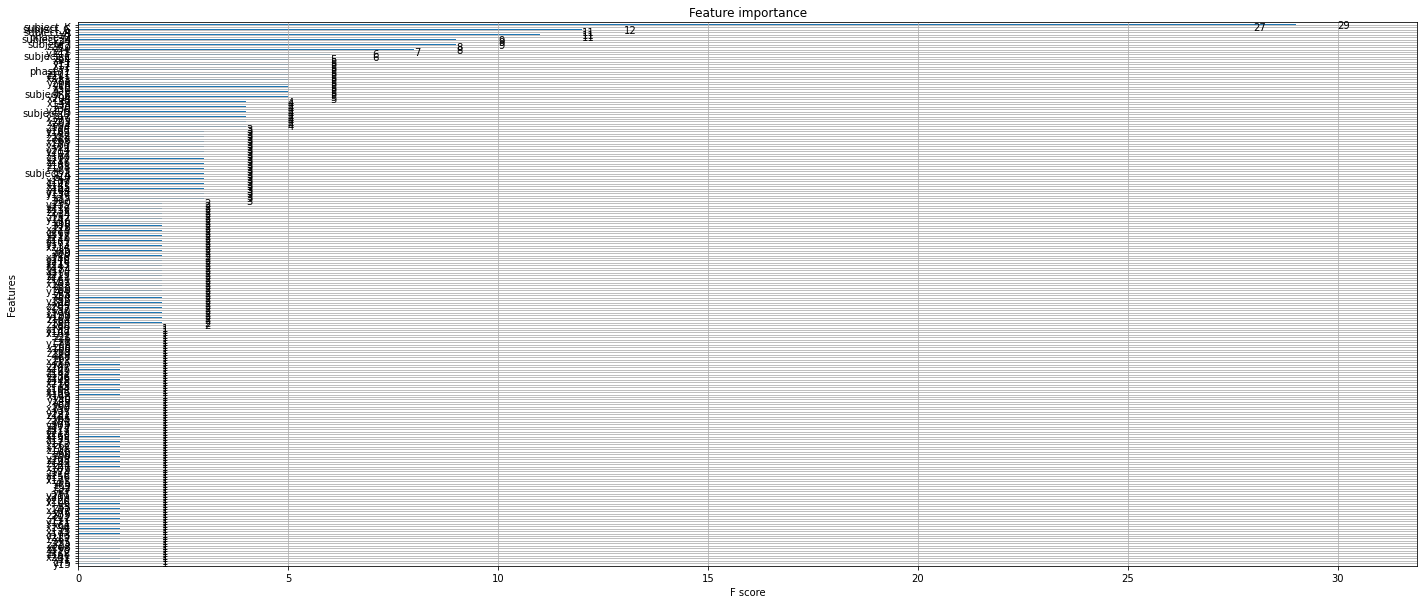

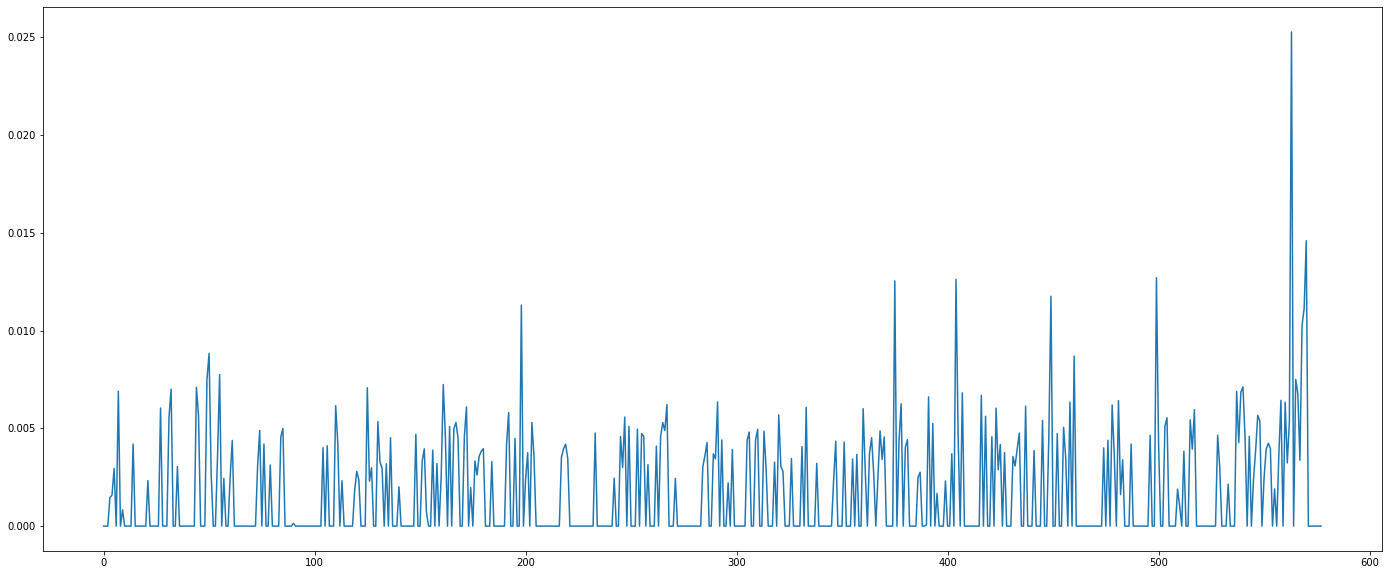

In [ ]:
model = xgb(random_state=42)
preds = model.fit(X_train, y_train).predict(X_val)
fig, ax = plt.subplots(figsize=(24, 10))
plot_importance(model, ax=ax)

plt.figure(figsize=(24, 10))
plt.plot(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [ ]:
'''
Above is difficult to interpret so we observe the matrix

We look at top 25 features to observe any pattern
'''
base_featimport = model.feature_importances_.reshape((1, 578)) 
base_featimport = pd.DataFrame(base_featimport, columns=X_train.columns).T
base_featimport = base_featimport.sort_values(by=0, ascending=False)
base_featimport[:25]

,0
subject_G,0.025284
phase_2,0.014602
z164,0.012707
z35,0.012624
z5,0.012545
z90,0.011756
y15,0.011308
phase_1,0.011132
subject_M,0.010258
x55,0.008836


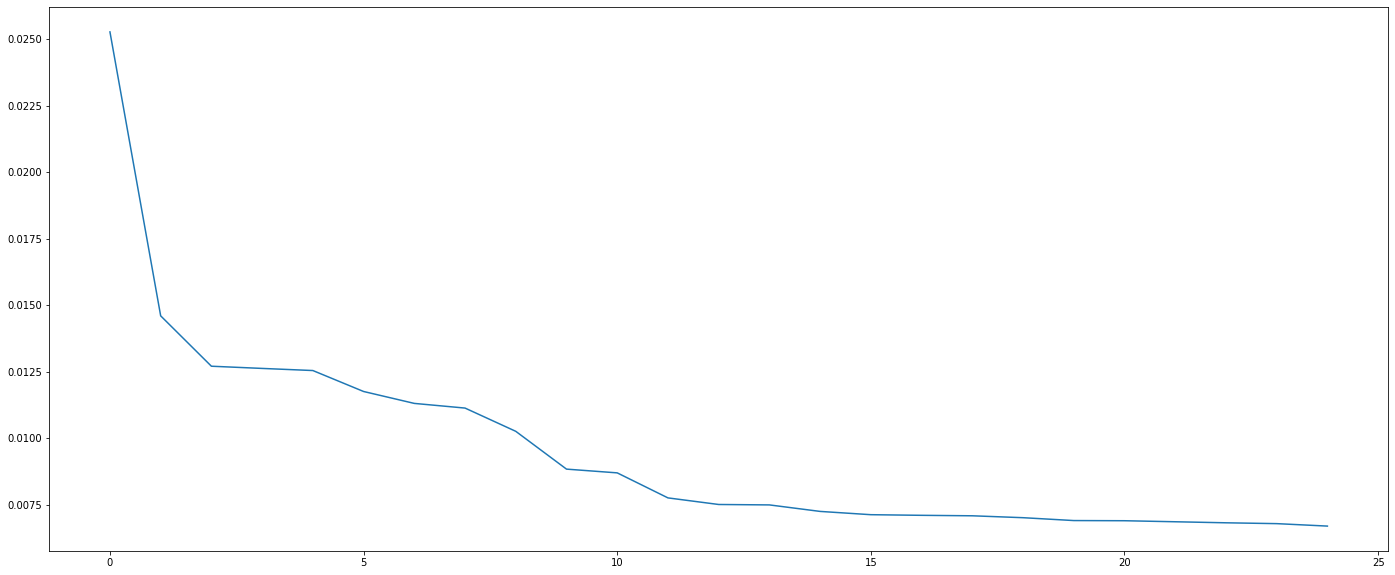

In [ ]:
'''
Replot top 25 features

we observe there are 5 or so features that contribute most significantly 
'''
plt.figure(figsize=(24, 10))
plt.plot(range(len(base_featimport[:25])), base_featimport[:25].to_numpy())
plt.show()

## Tuning XGBoost model

See notes as comments at the top of code blocks.

In [ ]:
'''
First run to tune model

Starting with:
- learning rate = 0.1
- n_estimators
- max_depth
- scale_pos_weight
'''
def xgb_param_selection(X, y):
    n_estimators = [25, 50, 75] 
    max_depth=[6, 8] 
    scale_pos_weight = [0.18, 0.33] 
    learning_rate = [0.1]
    objective = ['reg:logistic']
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth' : max_depth,
                  'scale_pos_weight':scale_pos_weight, 
                  'learning_rate': learning_rate,
                  'objective':objective}
    
    boost = xgb(use_label_encoder=False)
    grid_search = GridSearchCV(boost, param_grid, cv=3, n_jobs=-1,verbose=0)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search,grid_search.best_params_

start_time = time.time()
xgb_model,xgb_best_prama = xgb_param_selection(X_train,y_train)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)
print('Best param of XGB ',xgb_best_prama)
print('Best score', xgb_model.best_score_)

Training execution time (mins) 1.8895883758862813
Best param of XGB  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 75, 'objective': 'reg:logistic', 'scale_pos_weight': 0.33}
Best score 0.860674810936591


In [ ]:
'''
Second run to tune model

- we learned that max_depth and scale_pos_weight tested may 
have been too low (because highest in range was chosen by gridsearch)
- including wider range of n_estimators to test
'''

def xgb_param_selection(X, y):
    n_estimators = [25, 50, 70, 90, 110, 130, 150] 
    max_depth=[8, 15, 25] 
    scale_pos_weight = [0.33, 0.37, 0.40] 
    learning_rate = [0.1]
    objective = ['reg:logistic']
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth' : max_depth,
                  'scale_pos_weight':scale_pos_weight, 
                  'learning_rate': learning_rate,
                  'objective':objective}
    
    boost = xgb(use_label_encoder=False)
    grid_search = GridSearchCV(boost, param_grid, cv=3, n_jobs=-1,verbose=0)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search,grid_search.best_params_

start_time = time.time()
xgb_model,xgb_best_param = xgb_param_selection(X_train,y_train)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)
print('Best param of XGB',xgb_best_param)
print('Best score', xgb_model.best_score_)

Training execution time (mins) 19.656608355045318
Best param of XGB {'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 130, 'objective': 'reg:logistic', 'scale_pos_weight': 0.33}
Best score 0.8647469458987783


In [ ]:
'''
After first two runs, to understand the effect of n_estimators, we create
boxplots
'''
acc_scores = []
f1_scores = []
start_time = time.time()
trees = [50, 70, 90, 110, 130, 150]
for ne in trees:
    model = xgb(eta=0.1, max_depth=8, n_estimators=ne, objective='reg:logistic') 
    acc_score_list = cross_val_score(model, X, y, cv=3,n_jobs=-1) #returns accuracy
    f1_score_list = cross_val_score(model, X, y, cv=3, scoring='f1')
    acc_scores.append(acc_score_list)
    f1_scores.append(f1_score_list)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Training execution time (mins) 8.573770586649577


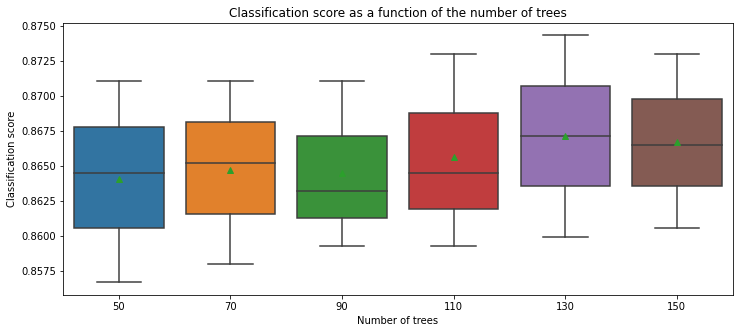

In [ ]:
box_df = pd.DataFrame([[50, 70, 90, 110, 130, 150], acc_scores]).T
box_df.columns = ['numoftrees','acc_score']
box_df = pd.DataFrame(np.array(acc_scores))
box_df['numoftrees'] = [50, 70, 90, 110, 130, 150]
box_df = box_df.melt(id_vars='numoftrees')

plt.figure(figsize=(12,5))
sns.boxplot(x="numoftrees", 
            y="value", 
            data=box_df, 
            showmeans=True);
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees');

In [ ]:
'''
We do the same for max depth (taking best n_estimators value)
'''
acc_scores = []
f1_scores = []
start_time = time.time()
depths = [6, 8, 15, 25]
for d in depths:
    model = xgb(eta=0.1, max_depth=d, n_estimators=90) 
    acc_score_list = cross_val_score(model, X, y, cv=3,n_jobs=-1) #returns accuracy
    f1_score_list = cross_val_score(model, X, y, cv=3, scoring='f1')
    acc_scores.append(acc_score_list)
    f1_scores.append(f1_score_list)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Training execution time (mins) 6.14916703303655


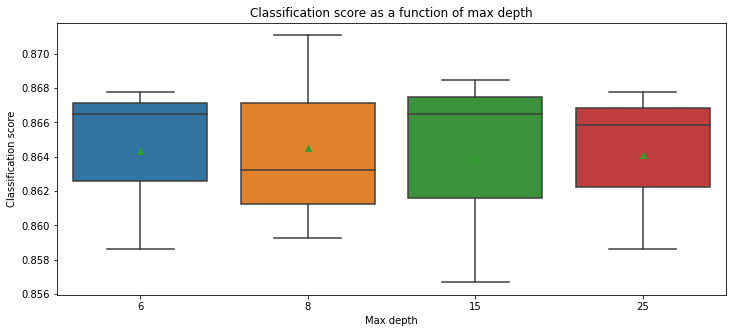

In [ ]:
box_df = pd.DataFrame([[6, 8, 15, 25], acc_scores]).T
box_df.columns = ['maxdepth','acc_score']
box_df = pd.DataFrame(np.array(acc_scores))
box_df['maxdepth'] = [6, 8, 15, 25]
box_df = box_df.melt(id_vars='maxdepth')

plt.figure(figsize=(12,5))
sns.boxplot(x="maxdepth", 
            y="value", 
            data=box_df, 
            showmeans=True);
plt.xlabel('Max depth')
plt.ylabel('Classification score')
plt.title('Classification score as a function of max depth');

**Discussion of boxplots for accuracy and f1 scores**

- Gridsearch suggested that n_estimators of 150 and max depth of 25 were the optimal value.
- The box plots do not necessarily show this clearly. 
- Looking at the plot for n_estimators: we observe that higher values tend to improve accuracy. The box for 130 seems to achieve higher accuracies than for 150, however, it also has a higher variance. Perhaps this is what we observe in the output for gridsearch.
- Looking at the plot for max_depth: we see this has less effect (at a value of n_estimators of 150) than changing values of n_estimators did. A value of 8 may have the best potential for a higher clasification score, however, gridsearch returned a max depth of 25.  We see this value has a lowest variance for the tested values, second to 6. 

### Best params returned after 2 runs

{'scale_pos_weight': 0.33, 'objective': 'reg:logistic', 'n_estimators': 150, 'max_depth': 25, 'learning_rate': 0.1}

In [ ]:
'''
- these optimizations +2% improvement in validation accuracy (from ~0.861 to 
~0.876)
- this was unexpected as we thought that increasing the estimators and depth 
would improve accuracy
'''
model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', scale_pos_weight=0.33) 
preds = model.fit(X_train, y_train).predict(X_val)
print('Train accuracy %s' % model.score(X_train, y_train)) 
print('Validation accuracy %s' % accuracy_score(preds, y_val)) # 0.876

Train accuracy 1.0
Validation accuracy 0.868237347294939


### Continuing with third run

In [ ]:
'''
Third run to tune model

- we kept the best params from the first two runs
- additionally we tested:
  - colsample_bytree [0.5, 0.55, 0.6, 0.65, 0.7, 0.8] 
  - min_child_weight [0.5, 1, 3, 5]
  - subsample [0.5, 0.55, 0.6, 0.65, 0.7, 0.8] 
'''

def xgb_param_selection(X, y):
    n_estimators = [150] 
    max_depth=[25] 
    scale_pos_weight = [0.33] 
    learning_rate = [0.1]
    objective = ['reg:logistic']
    eval_metric = ['logloss']
    sub_sample = [0.5, 0.6, 0.7, 0.8]
    min_child_weight = [0.5, 1, 3, 5]
    colsample_bytree = [0.5, 0.6, 0.7]
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth' : max_depth,
                  'scale_pos_weight':scale_pos_weight, 
                  'learning_rate': learning_rate,
                  'objective':objective, 
                  'eval_metric':eval_metric,
                  'colsample_bytree':colsample_bytree,
                  'sub_sample':sub_sample,
                  'min_child_weight': min_child_weight}
    
    # build model
    boost = xgb(use_label_encoder=False)
    grid_search = GridSearchCV(boost, param_grid, cv=3, n_jobs=-1,verbose=0)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search,grid_search.best_params_

start_time = time.time()
xgb_model,xgb_best_prama = xgb_param_selection(X, y)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)
print('Best param of XGB',xgb_best_prama)
print('Best score', xgb_model.best_score_)

Training execution time (mins) 20.35051600933075
Best param of XGB {'colsample_bytree': 0.5, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 25, 'min_child_weight': 0.5, 'n_estimators': 150, 'objective': 'reg:logistic', 'scale_pos_weight': 0.33, 'sub_sample': 0.5}
Best score 0.8669284467713787


### Best params returned after 3 runs

{'colsample_bytree': 0.5, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 25, 'min_child_weight': 0.5, 'n_estimators': 150, 'objective': 'reg:logistic', 'scale_pos_weight': 0.33, 'sub_sample': 0.5}

In [ ]:
model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=3, colsample_bytree=0.5, 
            sub_sample =0.5, random_state=42, eval_metric='logloss') 
preds = model.fit(X_train, y_train).predict(X_val) 
print('Train accuracy %s' % model.score(X_train, y_train)) 
print('Validation accuracy %s' % accuracy_score(preds, y_val))

Train accuracy 1.0
Validation accuracy 0.8612565445026178


### Finding optimal threshold for tuned model

In [ ]:
'''
- using tuned hyperparameters
- using Youden's J statistic to identify threshold
'''
yhat = model.predict_proba(X_val)
yhat = yhat[:, 1] # keep probabilities for the positive outcome only
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat) # y_true score, y score

J = tpr - fpr 
ix = np.argmax(J)
opt_thresh = thresholds[ix]
print('Optimal predict prob threshold: %f' % (opt_thresh))

Optimal predict prob threshold: 0.879106


In [ ]:
'''
report for optimal threshold (on X_val, trained on X_train)
'''
def thresh_pred(model, X, thresh):
    return (model.predict_proba(X)[:,1] > thresh).astype(int)

pred = thresh_pred(model, X_val, opt_thresh)
print(metrics.classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.38      0.68      0.49       178
           1       0.93      0.80      0.86       968

    accuracy                           0.78      1146
   macro avg       0.66      0.74      0.68      1146
weighted avg       0.85      0.78      0.80      1146



**Discussion**

- We observe that this model has low precision for the 0 classification. We know that the 0 is the minority classification (~18/82 split as seen above). Low precision (or specificity) correspponds to the positive predictive value, or of those we specified as positive, how many are indeed positive.
- We observe that is has relatively high recall for both classifications. We know that recall is also known as sensitivity, or the true positive rate. How many positives do we get or "recall" of all the true positives.
- In aggregate this suggests our model is not identifying all of the 0 classifications

## Kaggle LB score: 0.66521

**Updated kaggle score for tuned model:**  0.66521 (+2%)

Notes
- this was submitting probabilities (not predicted classes)
- this is an improvement over the baseline XGBoost model, which scored 0.65321
- using the same model, and submitting predictions (with an optimized threshold) significantly reduced AUC to 0.57753
- therefore, going forward, we submitted probabilities to the kaggle leaderboard

# IV. Stacking models

Now that we have optimzied the XGBoost model. We will seek to combine it with other models.

## "Default" stacked model 

Using code from section 5 to create baseline, tsee if there is an improvement in our evaluation metrics.

In [18]:
SEED = 1337
NFOLDS = 3
kf = KFold(n_splits= NFOLDS,shuffle=True, random_state=SEED)

Xnp = X.to_numpy()
ynp = y.to_numpy()
X_trainnp = X_train.to_numpy()
y_trainnp = y_train.to_numpy()
X_valnp = X_val.to_numpy()
y_valnp = y_val.to_numpy()
X_testnp = X_test.to_numpy()

def get_oof(model, X, y, X_test):
  train_preds = np.zeros((X.shape[0],))
  test_preds = pd.DataFrame()

  # when testing models:
  # X -> X_train, y -> y_train, X_test -> X_val

  # when creating kaggle model:
  # X -> X, y -> y, X_test -> X_test

  for i, (train_ix, val_ix) in enumerate(kf.split(X)):
    X_train, y_train = X[train_ix], y[train_ix]
    X_val = X[val_ix] # "hold out" fold

    model.fit(X_train, y_train)

    train_preds[val_ix] = model.predict_proba(X_val)[:, 1] 

    test_pred = model.predict_proba(X_test)[:, 1] 
    test_preds[i] = test_pred
 
  test_preds['proba'] = test_preds.mean(axis=1)
  test_preds = test_preds['proba'].to_numpy()
  return train_preds.reshape(-1, 1), test_preds.reshape(-1,1)

In [19]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 100,
    'max_depth': 25,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025, 
    'probability':True
    }

In [20]:
# models
rf = RandomForestClassifier(**rf_params)
et = ExtraTreesClassifier(**et_params)
ada = AdaBoostClassifier(**ada_params)
gb = xgb(**gb_params)
svc = SVC(**svc_params)

In [21]:
# oof train and test predictions
et_oof_train, et_oof_val = get_oof(et, X_trainnp, y_trainnp, X_valnp) # Extra Trees
rf_oof_train, rf_oof_val = get_oof(rf, X_trainnp, y_trainnp, X_valnp) # Random Forest
ada_oof_train, ada_oof_val = get_oof(ada, X_trainnp, y_trainnp, X_valnp) # AdaBoost 
gb_oof_train, gb_oof_val = get_oof(gb, X_trainnp, y_trainnp, X_valnp) # Gradient Boost
svc_oof_train, svc_oof_val = get_oof(svc, X_trainnp, y_trainnp, X_valnp) # Support Vector Classifier

et_oof_X, et_oof_test = get_oof(et, Xnp, ynp, X_testnp) 
rf_oof_X, rf_oof_test = get_oof(rf, Xnp, ynp, X_testnp) 
ada_oof_X, ada_oof_test = get_oof(ada, Xnp, ynp, X_testnp) 
gb_oof_X, gb_oof_test = get_oof(gb, Xnp, ynp, X_testnp) 
svc_oof_X, svc_oof_test = get_oof(svc, Xnp, ynp, X_testnp)

In [17]:
base_predictions_train = pd.DataFrame( {'ExtraTrees': et_oof_train.ravel(), 
                                        'RandomForest': rf_oof_train.ravel(), 
                                        'AdaBoost': ada_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel(),
                                        'SVM': svc_oof_train.ravel()})
base_predictions_train[:25]

,ExtraTrees,RandomForest,AdaBoost,GradientBoost,SVM
0,0.657826,0.683709,0.498633,0.032347,0.641948
1,0.889973,0.893992,0.506577,0.999233,0.929661
2,0.808805,0.799073,0.517991,0.996208,0.878953
3,0.814633,0.821099,0.502287,0.994203,0.869041
4,0.836741,0.892730,0.505705,0.999628,0.895423
5,0.846725,0.866130,0.520530,0.997357,0.876926
6,0.804402,0.759553,0.499829,0.970676,0.762391
7,0.916786,0.896055,0.521371,0.999751,0.871584
8,0.847469,0.868212,0.505282,0.999102,0.882907
9,0.967903,0.926428,0.538572,0.999945,0.913308


In [18]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_val = np.concatenate((et_oof_val, rf_oof_val, ada_oof_val, gb_oof_val, svc_oof_val), axis=1)

x_ = np.concatenate((et_oof_X, rf_oof_X, ada_oof_X, gb_oof_X, svc_oof_X), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [19]:
# generate probabilities from meta model
meta_model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=3, colsample_bytree=0.5, 
            sub_sample =0.5, random_state=42, eval_metric='logloss').fit(x_train, y_train)

meta_probs = meta_model.predict_proba(x_val)[:, 1]

In [20]:
# re-generate probabilities from optimized XGBoost model
model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=3, colsample_bytree=0.5, 
            sub_sample =0.5, random_state=42, eval_metric='logloss').fit(X_train, y_train)
            
probs = model.predict_proba(X_val)[:, 1]

In [21]:
# calculate optimal threshold for stacked model
meta_fpr, meta_tpr, thresholds = metrics.roc_curve(y_val, meta_probs) 
J = meta_tpr - meta_fpr 
ix = np.argmax(J)
meta_opt_thresh = thresholds[ix]
print('Optimal predict prob threshold: %f' % (meta_opt_thresh))

Optimal predict prob threshold: 0.804157


In [22]:
# calculate optimal threshold for XGboost model
XGBoost_fpr, XGBoost_tpr, thresholds = metrics.roc_curve(y_val, probs) 
J = XGBoost_tpr - XGBoost_fpr 
ix = np.argmax(J)
opt_thresh = thresholds[ix]
print('Optimal predict prob threshold: %f' % (opt_thresh))

Optimal predict prob threshold: 0.923717


In [23]:
# print classification report
def thresh_pred(model, X, thresh):
    return (model.predict_proba(X)[:,1] > thresh).astype(int)

meta_preds = thresh_pred(meta_model, x_val, meta_opt_thresh)
preds = thresh_pred(model, X_val, opt_thresh)
print(metrics.classification_report(y_val, meta_preds))

              precision    recall  f1-score   support

           0       0.39      0.83      0.53       178
           1       0.96      0.76      0.85       968

    accuracy                           0.77      1146
   macro avg       0.67      0.79      0.69      1146
weighted avg       0.87      0.77      0.80      1146



In [24]:
# test accuracy on validation set
# first default threshold; then optimized threshold
print("Accuracy score with default threshold ", accuracy_score(y_val, thresh_pred(meta_model, x_val, 0.5)))
print("Accuracy score with optimized threshold", accuracy_score(y_val, thresh_pred(meta_model, x_val, meta_opt_thresh)))

Accuracy score with default threshold  0.8464223385689355
Accuracy score with optimized threshold 0.7705061082024433


In [25]:
# compare to optimized model; generate model on original dataset
print("Accuracy score with using baseline stacked model ", accuracy_score(y_val, meta_preds))
print("Accuracy score with optimized XGBoost model ", accuracy_score(y_val, preds))
print("ROC AUC score with using baseline stacked model ", metrics.roc_auc_score(y_val, meta_preds))
print("ROC AUC score with optimized XGBoost model ", metrics.roc_auc_score(y_val, preds))

Accuracy score with using baseline stacked model  0.7705061082024433
Accuracy score with optimized XGBoost model  0.7347294938917975
ROC AUC score with using baseline stacked model  0.7930866375708052
ROC AUC score with optimized XGBoost model  0.7810787909740923


**Discussion**

- We see the stacked model  more accurate (in terms of accuracy_score) and has a higher AUC despite only 5 models in it.
- We also observe that the optimzied threshold does not appear to improve accuracy (and we saw this earlier comparing submissions of the same model submitted to the kaggle LB, one with the default 0.5 threshold and another with an optimized threshold developed using the Youden's J statistics).
- That said, we do see that it improves AUC.

## Improving upon base stacked model

We will add 5 models to inrease the size of the meta model from 5 learners to 10 learners: 
- KNN
- Logistic Regression
- Naive Bayes 
- MLPClassifier
- LDA

### Adding Sklearn models (KNN, Logistic Regression, Naive Bayes, MLPClassifier, LDA)

In [22]:
knn = KNeighborsClassifier()
lr = LogisticRegression()
nb = GaussianNB()
mlp = MLPClassifier()
lda = LDA()

In [23]:
knn_oof_train, knn_oof_val = get_oof(knn, X_trainnp, y_trainnp, X_valnp) # KNN
lr_oof_train, lr_oof_val = get_oof(lr, X_trainnp, y_trainnp, X_valnp) # Logistic Regression
nb_oof_train, nb_oof_val = get_oof(nb, X_trainnp, y_trainnp, X_valnp) # Naive Bayes
mlp_oof_train, mlp_oof_val = get_oof(mlp, X_trainnp, y_trainnp, X_valnp) # MLPClassifier
lda_oof_train, lda_oof_val = get_oof(lda, X_trainnp, y_trainnp, X_valnp) # LDA

knn_oof_X, knn_oof_test = get_oof(knn, Xnp, ynp, X_testnp) 
lr_oof_X, lr_oof_test = get_oof(lr, Xnp, ynp, X_testnp) 
nb_oof_X, nb_oof_test = get_oof(nb, Xnp, ynp, X_testnp) 
mlp_oof_X, mlp_oof_test = get_oof(mlp, Xnp, ynp, X_testnp)
lda_oof_X, lda_oof_test = get_oof(lda, Xnp, ynp, X_testnp) 

In [28]:
# update meta feature set
updated_predictions = base_predictions_train
updated_predictions['KNeighborsClassifier'] = knn_oof_train.ravel()
updated_predictions['LogisticRegression'] = lr_oof_train.ravel()
updated_predictions['GaussianNB'] = nb_oof_train.ravel()
updated_predictions['MLPClassifier'] = mlp_oof_train.ravel()
updated_predictions['LDA'] = lda_oof_train.ravel()
updated_predictions[:25]

,ExtraTrees,RandomForest,AdaBoost,GradientBoost,SVM,KNeighborsClassifier,LogisticRegression,GaussianNB,MLPClassifier,LDA
0,0.657826,0.683709,0.498633,0.032347,0.641948,0.6,0.568693,6.247577e-191,0.215965,0.008103
1,0.889973,0.893992,0.506577,0.999233,0.929661,0.8,0.980339,1.755807e-57,0.991411,0.992741
2,0.808805,0.799073,0.517991,0.996208,0.878953,0.8,0.992122,1.000000e+00,0.999983,0.990457
3,0.814633,0.821099,0.502287,0.994203,0.869041,1.0,0.954182,1.787847e-06,0.962771,0.988245
4,0.836741,0.892730,0.505705,0.999628,0.895423,0.6,0.969116,1.404337e-69,0.967787,0.992398
5,0.846725,0.866130,0.520530,0.997357,0.876926,0.8,0.930397,5.812339e-71,0.942570,0.989035
6,0.804402,0.759553,0.499829,0.970676,0.762391,0.8,0.587441,1.000000e+00,0.721385,0.039447
7,0.916786,0.896055,0.521371,0.999751,0.871584,0.8,0.964730,2.066225e-15,0.983718,0.963793
8,0.847469,0.868212,0.505282,0.999102,0.882907,1.0,0.871256,1.806680e-78,0.945460,0.971885
9,0.967903,0.926428,0.538572,0.999945,0.913308,1.0,0.990198,1.000000e+00,0.998375,0.979633


In [29]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, knn_oof_train, lr_oof_train, nb_oof_train, mlp_oof_train, lda_oof_train), axis=1)
x_val = np.concatenate((et_oof_val, rf_oof_val, ada_oof_val, gb_oof_val, svc_oof_val, knn_oof_val, lr_oof_val, nb_oof_val, mlp_oof_val, lda_oof_val), axis=1)

x_ = np.concatenate((et_oof_X, rf_oof_X, ada_oof_X, gb_oof_X, svc_oof_X, knn_oof_X, lr_oof_X, nb_oof_X, mlp_oof_X, lda_oof_X), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, knn_oof_test, lr_oof_test, nb_oof_test, mlp_oof_test, lda_oof_test), axis=1)

In [ ]:
# get best parameters for XGBoost used in stacked model
def xgb_param_selection(X, y):
    n_estimators = [150, 175, 200, 250, 300] 
    max_depth=[25, 35, 45, 50] 
    scale_pos_weight = [0.33] 
    learning_rate = [0.1]
    objective = ['reg:logistic']
    eval_metric = ['logloss']
    sub_sample = [0.4, 0.5, 1]
    min_child_weight = [0.4, 0.5, 1]
    colsample_bytree = [0.3, 0.5, 0.7, 1]
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth' : max_depth,
                  'scale_pos_weight':scale_pos_weight, 
                  'learning_rate': learning_rate,
                  'objective':objective, 
                  'eval_metric':eval_metric,
                  'colsample_bytree':colsample_bytree,
                  'sub_sample':sub_sample,
                  'min_child_weight': min_child_weight}
    

    boost = xgb(use_label_encoder=False)
    grid_search = GridSearchCV(boost, param_grid, cv=3, n_jobs=-1,verbose=0)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search,grid_search.best_params_

start_time = time.time()
xgb_model,xgb_best_prama = xgb_param_selection(x_train, y_train)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)
print('Best param of XGB',xgb_best_prama)
print('Best score', xgb_model.best_score_)

Training execution time (mins) 12.144798405965169
Best param of XGB {'colsample_bytree': 0.5, 'eval_metric': 'logloss', 'learning_rate': 0.1, 'max_depth': 25, 'min_child_weight': 0.5, 'n_estimators': 150, 'objective': 'reg:logistic', 'scale_pos_weight': 0.33, 'sub_sample': 0.4}
Best score 0.8574752763234438


In [30]:
# generate probabilities from meta model
meta_model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=0.5, colsample_bytree=0.5, 
            sub_sample =0.4, random_state=42, eval_metric='logloss').fit(x_train, y_train)

meta_probs = meta_model.predict_proba(x_val)[:, 1]

In [31]:
# calculating optimal threshold for stacked model
meta_fpr, meta_tpr, thresholds = metrics.roc_curve(y_val, meta_probs) 
J = meta_tpr - meta_fpr 
ix = np.argmax(J)
meta_opt_thresh = thresholds[ix]
print('Optimal predict prob threshold: %f' % (meta_opt_thresh))

Optimal predict prob threshold: 0.863123


In [32]:
# print classification report
def thresh_pred(model, X, thresh):
    return (model.predict_proba(X)[:,1] > thresh).astype(int)

meta_preds = thresh_pred(meta_model, x_val, meta_opt_thresh)
print(metrics.classification_report(y_val, meta_preds))

              precision    recall  f1-score   support

           0       0.45      0.77      0.57       178
           1       0.95      0.83      0.89       968

    accuracy                           0.82      1146
   macro avg       0.70      0.80      0.73      1146
weighted avg       0.87      0.82      0.84      1146



In [33]:
# compare to optimized model; generate model on original dataset
print("Accuracy score with updated stacked model ", accuracy_score(y_val, meta_preds))
print("ROC AUC score with updated stacked model ", metrics.roc_auc_score(y_val, meta_preds))
print("Accuracy score with optimized XGBoost model ", accuracy_score(y_val, preds))
print("ROC AUC score with optimized XGBoost model ", metrics.roc_auc_score(y_val, preds))

Accuracy score with updated stacked model  0.8202443280977313
ROC AUC score with updated stacked model  0.7996041879468846
Accuracy score with optimized XGBoost model  0.7347294938917975
ROC AUC score with optimized XGBoost model  0.7810787909740923


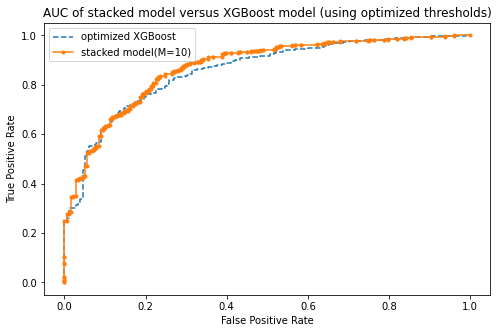

In [34]:
# compare ROC -- stacked model vs. XGBoost alone
plt.figure(figsize=(8, 5))
plt.plot(XGBoost_fpr, XGBoost_tpr, linestyle='--', label='optimized XGBoost')
plt.plot(meta_fpr, meta_tpr, marker='.', label='stacked model(M=10)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUC of stacked model versus XGBoost model (using optimized thresholds)")
plt.legend()
plt.show()

**Discussion**

- We observe that our stacked model continues to have a higher AUC than the optimized XGBoost model. The stacked model (with 10 classifiers) has an AUC of 0.7996 versus XGBoost's 0.780. 
- The accuracy is likewise higher for the stacked model.

### See feature importances for stack model(M=10)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_importance(meta_model, ax=ax)

plt.figure(figsize=(20, 8))
plt.plot(range(len(meta_model.feature_importances_)), meta_model.feature_importances_)
plt.show()

**Discussion**
- Feature 3 corresponds to the gradient boosting machine. This is the greatest contributor to the model based on the feature importances plot.
- However, this takes the longset to train and the second best feature was contributed by the LDA model.
- Therefore, to further improve the model, we will add 5 more LDAs and have a total of 15 models in our stacked model.

### Add 5 more LDA models (informed by feature importances plot)

In [24]:
lda2 = LDA()
lda3 = LDA()
lda4 = LDA()
lda5 = LDA()
lda6 = LDA()

In [25]:
lda2_oof_train, lda2_oof_val = get_oof(lda2, X_trainnp, y_trainnp, X_valnp) 
lda3_oof_train, lda3_oof_val = get_oof(lda3, X_trainnp, y_trainnp, X_valnp) 
lda4_oof_train, lda4_oof_val = get_oof(lda4, X_trainnp, y_trainnp, X_valnp) 
lda5_oof_train, lda5_oof_val = get_oof(lda5, X_trainnp, y_trainnp, X_valnp) 
lda6_oof_train, lda6_oof_val = get_oof(lda6, X_trainnp, y_trainnp, X_valnp) 

lda2_oof_X, lda2_oof_test = get_oof(lda2, Xnp, ynp, X_testnp) 
lda3_oof_X, lda3_oof_test = get_oof(lda3, Xnp, ynp, X_testnp) 
lda4_oof_X, lda4_oof_test = get_oof(lda4, Xnp, ynp, X_testnp) 
lda5_oof_X, lda5_oof_test = get_oof(lda5, Xnp, ynp, X_testnp) 
lda6_oof_X, lda6_oof_test = get_oof(lda6, Xnp, ynp, X_testnp) 

In [26]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, knn_oof_train, lr_oof_train, nb_oof_train, mlp_oof_train, lda_oof_train, lda2_oof_train, lda3_oof_train, lda4_oof_train, lda5_oof_train, lda6_oof_train), axis=1)
x_val = np.concatenate((et_oof_val, rf_oof_val, ada_oof_val, gb_oof_val, svc_oof_val, knn_oof_val, lr_oof_val, nb_oof_val, mlp_oof_val, lda_oof_val, lda2_oof_val, lda3_oof_val, lda4_oof_val, lda5_oof_val, lda6_oof_val), axis=1)

x_ = np.concatenate((et_oof_X, rf_oof_X, ada_oof_X, gb_oof_X, svc_oof_X, knn_oof_X, lr_oof_X, nb_oof_X, mlp_oof_X, lda_oof_X, lda2_oof_X, lda3_oof_X, lda4_oof_X, lda5_oof_X, lda6_oof_X), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, knn_oof_test, lr_oof_test, nb_oof_test, mlp_oof_test, lda_oof_test, lda2_oof_test, lda3_oof_test, lda4_oof_test, lda5_oof_test, lda6_oof_test), axis=1)

In [38]:
# generate probabilities from meta model
meta_model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=0.5, colsample_bytree=0.5, 
            sub_sample =0.4, random_state=42, eval_metric='logloss').fit(x_train, y_train)

meta_probs = meta_model.predict_proba(x_val)[:, 1]

In [39]:
# calculating optimal threshold for stacked model
meta_fpr, meta_tpr, thresholds = metrics.roc_curve(y_val, meta_probs) 
J = meta_tpr - meta_fpr 
ix = np.argmax(J)
meta_opt_thresh = thresholds[ix]
print('Optimal predict prob threshold: %f' % (meta_opt_thresh))

Optimal predict prob threshold: 0.829333


In [40]:
# print classification report
def thresh_pred(model, X, thresh):
    return (model.predict_proba(X)[:,1] > thresh).astype(int)

meta_preds = thresh_pred(meta_model, x_val, meta_opt_thresh)
print(metrics.classification_report(y_val, meta_preds))

              precision    recall  f1-score   support

           0       0.47      0.75      0.58       178
           1       0.95      0.85      0.90       968

    accuracy                           0.83      1146
   macro avg       0.71      0.80      0.74      1146
weighted avg       0.87      0.83      0.85      1146



In [41]:
# compare to optimized model; generate model on original dataset
print("Accuracy score with updated stacked model ", accuracy_score(y_val, meta_preds))
print("ROC AUC score with updated stacked model ", metrics.roc_auc_score(y_val, meta_preds))
print("Accuracy score with optimized XGBoost model ", accuracy_score(y_val, preds))
print("ROC AUC score with optimized XGBoost model ", metrics.roc_auc_score(y_val, preds))

Accuracy score with updated stacked model  0.8324607329842932
ROC AUC score with updated stacked model  0.7976657535518618
Accuracy score with optimized XGBoost model  0.7347294938917975
ROC AUC score with optimized XGBoost model  0.7810787909740923


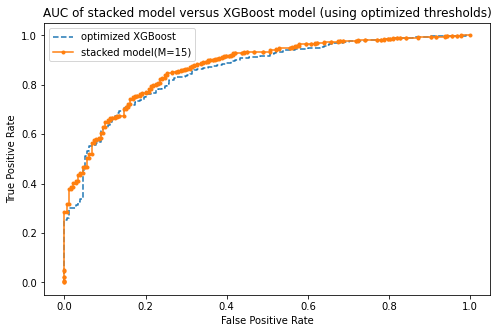

In [42]:
# compare ROC -- stacked model vs. XGBoost alone
plt.figure(figsize=(8, 5))
plt.plot(XGBoost_fpr, XGBoost_tpr, linestyle='--', label='optimized XGBoost')
plt.plot(meta_fpr, meta_tpr, marker='.', label='stacked model(M=15)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUC of stacked model versus XGBoost model (using optimized thresholds)")
plt.legend()
plt.show()

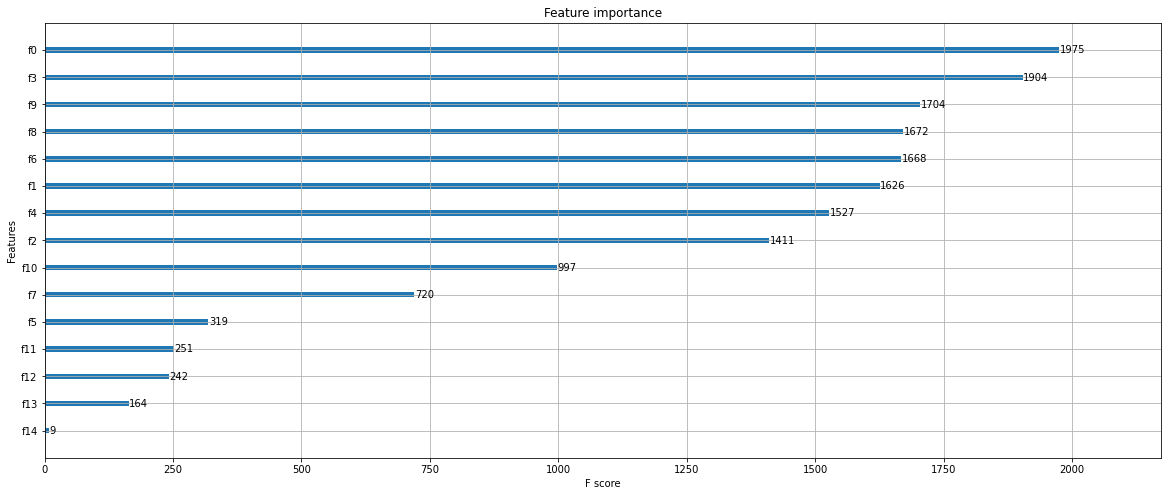

In [43]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_importance(meta_model, ax=ax);

**Discussion**
- Adding 5 LDA models did not substantially improve the model
- The AUC went from 0.7996 to 0.798; however, the accuracy did improve from 0.82 to 0.83
- f0 contributed significantly. This is ET.
- We will try adding 5 more of those.


### Add 5 more ET models

In [44]:
et2 = ExtraTreesClassifier(n_estimators = 500, criterion ='entropy', max_features = 8)
et3 = ExtraTreesClassifier(n_estimators = 500, criterion ='entropy', max_features = 8)
et4 = ExtraTreesClassifier(n_estimators = 500, criterion ='entropy', max_features = 8)
et5 = ExtraTreesClassifier(n_estimators = 500, criterion ='entropy', max_features = 8)
et6 = ExtraTreesClassifier(n_estimators = 500, criterion ='entropy', max_features = 8)

In [45]:
et2_oof_train, et2_oof_val = get_oof(et2, X_trainnp, y_trainnp, X_valnp) 
et3_oof_train, et3_oof_val = get_oof(et3, X_trainnp, y_trainnp, X_valnp) 
et4_oof_train, et4_oof_val = get_oof(et4, X_trainnp, y_trainnp, X_valnp) 
et5_oof_train, et5_oof_val = get_oof(et5, X_trainnp, y_trainnp, X_valnp) 
et6_oof_train, et6_oof_val = get_oof(et6, X_trainnp, y_trainnp, X_valnp)

et2_oof_X, et2_oof_test = get_oof(et2, Xnp, ynp, X_testnp) 
et3_oof_X, et3_oof_test = get_oof(et3, Xnp, ynp, X_testnp) 
et4_oof_X, et4_oof_test = get_oof(et4, Xnp, ynp, X_testnp) 
et5_oof_X, et5_oof_test = get_oof(et5, Xnp, ynp, X_testnp) 
et6_oof_X, et6_oof_test = get_oof(et6, Xnp, ynp, X_testnp)

In [47]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, knn_oof_train, lr_oof_train, nb_oof_train, mlp_oof_train, lda_oof_train, lda2_oof_train, lda3_oof_train, lda4_oof_train, lda5_oof_train, lda6_oof_train, et2_oof_train, et3_oof_train, et4_oof_train, et5_oof_train, et6_oof_train), axis=1)
x_val = np.concatenate(( et_oof_val, rf_oof_val, ada_oof_val, gb_oof_val, svc_oof_val, knn_oof_val, lr_oof_val, nb_oof_val, mlp_oof_val, lda_oof_val, lda2_oof_val, lda3_oof_val, lda4_oof_val, lda5_oof_val, lda6_oof_val, et2_oof_val, et3_oof_val, et4_oof_val, et5_oof_val, et6_oof_val), axis=1)

x_ = np.concatenate(( et_oof_X, rf_oof_X, ada_oof_X, gb_oof_X, svc_oof_X, knn_oof_X, lr_oof_X, nb_oof_X, mlp_oof_X, lda_oof_X, lda2_oof_X, lda3_oof_X, lda4_oof_X, lda5_oof_X, lda6_oof_X, et2_oof_X, et3_oof_X, et4_oof_X, et5_oof_X, et6_oof_X), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, knn_oof_test, lr_oof_test, nb_oof_test, mlp_oof_test, lda_oof_test, lda2_oof_test, lda3_oof_test, lda4_oof_test, lda5_oof_test, lda6_oof_test, et2_oof_test, et3_oof_test, et4_oof_test, et5_oof_test, et6_oof_test), axis=1)

In [48]:
# generate probabilities from meta model
meta_model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=0.5, colsample_bytree=0.5, 
            sub_sample =0.4, random_state=42, eval_metric='logloss').fit(x_train, y_train)

meta_probs = meta_model.predict_proba(x_val)[:, 1]

In [49]:
# calculating optimal threshold for stacked model
meta_fpr, meta_tpr, thresholds = metrics.roc_curve(y_val, meta_probs) 
J = meta_tpr - meta_fpr 
ix = np.argmax(J)
meta_opt_thresh = thresholds[ix]
print('Optimal predict prob threshold: %f' % (meta_opt_thresh))

Optimal predict prob threshold: 0.933669


In [50]:
# print classification report
def thresh_pred(model, X, thresh):
    return (model.predict_proba(X)[:,1] > thresh).astype(int)

meta_preds = thresh_pred(meta_model, x_val, meta_opt_thresh)
print(metrics.classification_report(y_val, meta_preds))

              precision    recall  f1-score   support

           0       0.40      0.83      0.54       178
           1       0.96      0.77      0.86       968

    accuracy                           0.78      1146
   macro avg       0.68      0.80      0.70      1146
weighted avg       0.87      0.78      0.81      1146



In [51]:
print("Accuracy score with updated stacked model ", accuracy_score(y_val, meta_preds))
print("ROC AUC score with updated stacked model ", metrics.roc_auc_score(y_val, meta_preds))

Accuracy score with updated stacked model  0.7818499127399651
ROC AUC score with updated stacked model  0.799801513603863


**Discussion**
- No notable difference for this model. We will go with the previous model.

## Stacked model on kaggle leaderboard

15 stacked models. Extra trees, Adaboost, SVC, Gradient boosting machine, random forest, logistic regression, knn, naive bayes, mlp, and 5 lda models. 

In [27]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, knn_oof_train, lr_oof_train, nb_oof_train, mlp_oof_train, lda_oof_train, lda2_oof_train, lda3_oof_train, lda4_oof_train, lda5_oof_train, lda6_oof_train), axis=1)
x_val = np.concatenate((et_oof_val, rf_oof_val, ada_oof_val, gb_oof_val, svc_oof_val, knn_oof_val, lr_oof_val, nb_oof_val, mlp_oof_val, lda_oof_val, lda2_oof_val, lda3_oof_val, lda4_oof_val, lda5_oof_val, lda6_oof_val), axis=1)

x_ = np.concatenate((et_oof_X, rf_oof_X, ada_oof_X, gb_oof_X, svc_oof_X, knn_oof_X, lr_oof_X, nb_oof_X, mlp_oof_X, lda_oof_X, lda2_oof_X, lda3_oof_X, lda4_oof_X, lda5_oof_X, lda6_oof_X), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, knn_oof_test, lr_oof_test, nb_oof_test, mlp_oof_test, lda_oof_test, lda2_oof_test, lda3_oof_test, lda4_oof_test, lda5_oof_test, lda6_oof_test), axis=1)

In [31]:
kaggle_model = xgb(eta=0.1, max_depth=25, n_estimators=150, objective='reg:logistic', 
            scale_pos_weight=0.33, min_child_weight=0.5, colsample_bytree=0.5, 
            sub_sample =0.4, random_state=42, eval_metric='logloss').fit(x_, y)

meta_probs = kaggle_model.predict_proba(x_test)[:, 1]

submission_df = pd.DataFrame()
submission_df['id'] = range(0,len(test))
submission_df['output'] = np.where(meta_probs>0.82933,1,0)

submission_df['output'].value_counts()
submission_df.to_csv('submission_MS2.csv',index=False)
!cp submission_MS2.csv "drive/My Drive/"

### Kaggle LB score submitting classifications (optimal threshold): 0.58827

### Kaggle LB score submitting probabilities: 0.64981



# V. XGBoost round 2

We changed how we processed the feature set.

Then we ran an optimized XGboost model on this revised feature set.

Our final model to kaggle is just an XGboost model on this feature set. This performed better than our stacked models.

### Pre-processing the feature set differently

In [32]:
def normalize(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.values),scaler

def apply_kmean(data,features,n_clusters):
    data_features,scaler = normalize(data[features])
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(data_features)
    return kmeans.labels_,kmeans,scaler

def create_feat(train,test):
    
    # Extract the column which has only one value
    one_value_col=[]
    for col in train.columns:
        if train[col].nunique() ==1:
            #print(train_data[col].nunique())
            one_value_col.append(col)

    # drop all columns which has only one value
    train = train.drop(columns=one_value_col,axis=1,errors='ignore')
    test = test.drop(columns=one_value_col,axis=1,errors='ignore')

    # drop columns which have bad distribution 
    drop_col = ['x2','x3','x40','x47','x101','x102','x118',
                'y2','y3','y40','y46','y47','y102','y117','y118',
                'z2','z3','z46','z47','z102','z117','z118','z119']+\
                ['x45','x46','x115','x116','x117',
                 'y41','y45','y101','y116','z41','z101']
    
    
    train = train.drop(columns=drop_col,axis=1,errors='ignore')
    test = test.drop(columns=drop_col,axis=1,errors='ignore')
    
    cat_col=[]
    for col in train.columns:
        if train[col].nunique() <= 11  and \
            col not in one_value_col and \
            col != 'output' and \
            col not in drop_col :
            #print(train_data[col].nunique())
            cat_col.append(col)

    numeric_feat = list(set(train.columns)-set(cat_col+['output']))
    
    train['all_clusters'],kmeans,scaler = apply_kmean(train,numeric_feat,n_clusters=5)
    test['all_clusters'] = kmeans.predict(scaler.transform(test[numeric_feat]))
    
    x_features = [feat for feat in numeric_feat if 'x' in feat]
    y_features = [feat for feat in numeric_feat if 'y' in feat]
    z_features = [feat for feat in numeric_feat if 'z' in feat]
    
    # Define cluster for x,y and z features
    print('cluster')
    train['x_clusters'],x_kmeans,x_scaler = apply_kmean(train,x_features,n_clusters=5)
    train['y_clusters'],y_kmeans,y_scaler = apply_kmean(train,y_features,n_clusters=5)
    train['z_clusters'],z_kmeans,z_scaler = apply_kmean(train,z_features,n_clusters=5)
    
    test['x_clusters'] = x_kmeans.predict(x_scaler.transform(test[x_features]))
    test['y_clusters'] = y_kmeans.predict(y_scaler.transform(test[y_features]))
    test['z_clusters'] = z_kmeans.predict(z_scaler.transform(test[z_features]))
    
    #train['x_y_clusters'] = train['x_clusters'].astype('str')+'_'+train['y_clusters'].astype('str')
    #train['x_z_clusters'] = train['x_clusters'].astype('str')+'_'+train['z_clusters'].astype('str')
    #train['z_y_clusters'] = train['z_clusters'].astype('str')+'_'+train['y_clusters'].astype('str')
    #train['x_y_z_clusters'] = train['x_clusters'].astype('str')+'_'+train['y_clusters'].astype('str')+'_'+train['z_clusters'].astype('str')
    
    #test['x_y_clusters'] = test['x_clusters'].astype('str')+'_'+test['y_clusters'].astype('str')
    #test['x_z_clusters'] = test['x_clusters'].astype('str')+'_'+test['z_clusters'].astype('str')
    #test['z_y_clusters'] = test['z_clusters'].astype('str')+'_'+test['y_clusters'].astype('str')
    #test['x_y_z_clusters'] = test['x_clusters'].astype('str')+'_'+test['y_clusters'].astype('str')+'_'+test['z_clusters'].astype('str')

    cluster_cols = ['x_clusters','y_clusters','z_clusters','all_clusters']
                  #'x_y_clusters','x_z_clusters','z_y_clusters',
                  #'x_y_z_clusters']
    train = pd.get_dummies(train,columns=cluster_cols)
    test = pd.get_dummies(test,columns=cluster_cols)
    
    
    #PCA
    print('pca')
    
    pca_scaler = StandardScaler()
    
    pca_scaler_x = StandardScaler()
    pca_scaler_y = StandardScaler()
    pca_scaler_z = StandardScaler()
    
    a = pca_scaler.fit_transform(train[numeric_feat])
    
    x = pca_scaler_x.fit_transform(train[x_features])
    y = pca_scaler_y.fit_transform(train[y_features])
    z = pca_scaler_z.fit_transform(train[z_features])
    
    a_t = pca_scaler.fit_transform(test[numeric_feat])
    
    x_t = pca_scaler_x.transform(test[x_features])
    y_t = pca_scaler_y.transform(test[y_features])
    z_t = pca_scaler_z.transform(test[z_features])
    
    a_pca = PCA(n_components=3).fit(a)
    
    x_pca = PCA(n_components=3).fit(x)
    y_pca = PCA(n_components=3).fit(y)
    z_pca = PCA(n_components=3).fit(z)
    
    train[['pca1','pca2','pca3']] = a_pca.transform(a)
    test[['pca1','pca2','pca3']] = a_pca.transform(a_t)
    
    train[['x_pca1','x_pca2','x_pca3']] = x_pca.transform(x)
    test[['x_pca1','x_pca2','x_pca3']] = x_pca.transform(x_t)
    
    train[['y_pca1','y_pca2','y_pca3']] = y_pca.transform(y)
    test[['y_pca1','y_pca2','y_pca3']] = y_pca.transform(y_t)
    
    train[['z_pca1','z_pca2','z_pca3']] = z_pca.transform(z)
    test[['z_pca1','z_pca2','z_pca3']] = z_pca.transform(z_t)
    
    #t-sne
#     print('t-sne')
#     train['type'] = 'train'
#     test['type'] = 'test'

#     tsne_df = pd.concat([train[x_features+y_features+z_features+['type']],test[x_features+y_features+z_features+['type']]],axis=0)
#     tsne_df[['x_tsne1','x_tsne2','x_tsne3']] = TSNE(n_components=3).fit_transform(tsne_df[x_features])
#     tsne_df[['y_tsne1','y_tsne2','y_tsne3']] = TSNE(n_components=3).fit_transform(tsne_df[y_features])
#     tsne_df[['z_tsne1','z_tsne2','z_tsne3']] = TSNE(n_components=3).fit_transform(tsne_df[z_features])


#     train[['x_tsne1','x_tsne2','x_tsne3']] = tsne_df[tsne_df.type=='train'][['x_tsne1','x_tsne2','x_tsne3']].reset_index()
#     test[['x_tsne1','x_tsne2','x_tsne3']] = tsne_df[tsne_df.type=='test'][['x_tsne1','x_tsne2','x_tsne3']].reset_index()

#     train[['y_tsne1','y_tsne2','y_tsne3']] = tsne_df[tsne_df.type=='train'][['y_tsne1','y_tsne2','y_tsne3']].reset_index()
#     test[['y_tsne1','y_tsne2','y_tsne3']] = tsne_df[tsne_df.type=='test'][['y_tsne1','y_tsne2','y_tsne3']].reset_index()

#     train[['z_tsne1','z_tsne2','z_tsne3']] = tsne_df[tsne_df.type=='train'][['z_tsne1','z_tsne2','z_tsne3']].reset_index()
#     test[['z_tsne1','z_tsne2','z_tsne3']] = tsne_df[tsne_df.type=='test'][['z_tsne1','z_tsne2','z_tsne3']].reset_index()

#     train = train.drop(columns=['type'],axis=1)
#     test = test.drop(columns=['type'],axis=1)

    # combine features
    print('combine cat feat')
    train['subject_phase'] = train['subject']+'_'+train['phase'].astype('str')
    train['subject_state'] = train['subject']+'_'+train['state']
    train['state_phase'] = train['state']+'_'+train['phase'].astype('str')
    train['subject_phase_state'] = train['subject']+'_'+train['phase'].astype('str')+'_'+train['state']
    
    test['subject_phase'] = test['subject']+'_'+test['phase'].astype('str')
    test['subject_state'] = test['subject']+'_'+test['state']
    test['state_phase'] = test['state']+'_'+test['phase'].astype('str')
    test['subject_phase_state'] = test['subject']+'_'+test['phase'].astype('str')+'_'+test['state']
    
    # one hot col
    new_cols = ['subject_phase','subject_state','state_phase','subject_phase_state']
    
    train = pd.get_dummies(train,columns=new_cols)
    test = pd.get_dummies(test,columns=new_cols)
    
    # apply one hot encoding 
    train = pd.get_dummies(train,columns=cat_col)
    test = pd.get_dummies(test,columns=cat_col)

    test['output']=-99
    
    test[list(set(train.columns)-set(test.columns))]=0
    
    return train,test

In [33]:
train,test = create_feat(train_data,test_data)

cluster
pca
combine cat feat


In [34]:
print(f'train shape : {train.shape} | test shape : {test.shape}')

train shape : (4584, 870) | test shape : (1732, 913)


In [35]:
X = train.drop(columns=['output'])
y = train['output']
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y)

print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(3667, 869) (917, 869) (3667,) (917,)


In [36]:
extra_tree_forest = ExtraTreesClassifier(n_estimators = 500,
                                        criterion ='entropy', max_features = 8)
# Training the model
extra_tree_forest.fit(X, y)
  
# Computing the importance of each feature
feature_importance = extra_tree_forest.feature_importances_
  
# Normalizing the individual importances
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        extra_tree_forest.estimators_],
                                        axis = 0)

In [37]:
imp_feat_df = pd.DataFrame(columns=['feat','score'])
imp_feat_df['feat'] = X.columns
imp_feat_df['score'] = feature_importance_normalized

imp_feat_df = imp_feat_df.sort_values(by=['score'],ascending=False)
imp_feat_df.head()

,feat,score
854,subject_G,0.023124
601,subject_state_G_C,0.008742
575,subject_phase_M_2,0.008490
857,subject_K,0.008146
556,subject_phase_G_1,0.006729


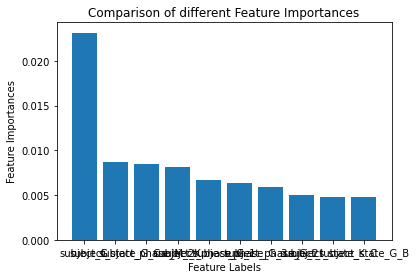

In [38]:
# Plotting a Bar Graph to compare the models

plt.bar(imp_feat_df['feat'].head(10),imp_feat_df['score'].head(10) )
plt.xlabel('Feature Labels')
plt.ylabel('Feature Importances')
plt.title('Comparison of different Feature Importances')
plt.show()

### Get important features

We grab the important features which came from ExtraTreeClassifier and get top 100 numeric features from it

In [79]:
imp_feat = imp_feat_df

imp_feat_l = imp_feat['feat']

cat_feat= ['subject','phase','state']

imp_feat_list = [f for f in imp_feat_l if ('x' in f or 'y' in f or 'z' in f) and ('pca' not in f) ][:100]

final_feat_list = cat_feat + imp_feat_list

train_data = train_data[final_feat_list+['output']]
test_data = test_data[final_feat_list]

### Prepare data for XGBoost
- Create new features from the existing features:
    * Apply kmean clustering on all numerical features with 5 clusters to get all cluster features.
    * Apply kmean clustering on x, y and z features individual with 5 clusters each and get the x_clusters, y_cluster & z_clusters as new features.
    * Apply pca on all features with 3 PCA and get the three new features
    * Apply pca on all three type of features x, y & z individual with three PCA for each and get total 9 features.
    * Combine all categorical features `subject`, `phase` and `state` with each other and get the features.

In [39]:
def normalize(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.values),scaler

def apply_kmean(data,features,n_clusters):
    data_features,scaler = normalize(data[features])
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000).fit(data_features)
    return kmeans.labels_,kmeans,scaler

def create_feat(train,test):
    
    # Extract the column which has only one value
    one_value_col=[]
    for col in train.columns:
        if train[col].nunique() ==1:
            #print(train_data[col].nunique())
            one_value_col.append(col)

    # drop all columns which has only one value
    train = train.drop(columns=one_value_col,axis=1,errors='ignore')
    test = test.drop(columns=one_value_col,axis=1,errors='ignore')

    # drop columns which have bad distribution 
    drop_col = ['x2','x3','x40','x47','x101','x102','x118',
                'y2','y3','y40','y46','y47','y102','y117','y118',
                'z2','z3','z46','z47','z102','z117','z118','z119']+\
                ['x45','x46','x115','x116','x117',
                 'y41','y45','y101','y116','z41','z101']
    
    
    train = train.drop(columns=drop_col,axis=1,errors='ignore')
    test = test.drop(columns=drop_col,axis=1,errors='ignore')
    
    cat_col=[]
    for col in train.columns:
        if train[col].nunique() <= 11  and \
            col not in one_value_col and \
            col != 'output' and \
            col not in drop_col :
            #print(train_data[col].nunique())
            cat_col.append(col)

    numeric_feat = list(set(train.columns)-set(cat_col+['output']))
    
    train['all_clusters'],kmeans,scaler = apply_kmean(train,numeric_feat,n_clusters=5)
    test['all_clusters'] = kmeans.predict(scaler.transform(test[numeric_feat]))
    
    x_features = [feat for feat in numeric_feat if 'x' in feat]
    y_features = [feat for feat in numeric_feat if 'y' in feat]
    z_features = [feat for feat in numeric_feat if 'z' in feat]
    
    # Define cluster for x,y and z features
    print('cluster')
    train['x_clusters'],x_kmeans,x_scaler = apply_kmean(train,x_features,n_clusters=5)
    train['y_clusters'],y_kmeans,y_scaler = apply_kmean(train,y_features,n_clusters=5)
    train['z_clusters'],z_kmeans,z_scaler = apply_kmean(train,z_features,n_clusters=5)
    
    test['x_clusters'] = x_kmeans.predict(x_scaler.transform(test[x_features]))
    test['y_clusters'] = y_kmeans.predict(y_scaler.transform(test[y_features]))
    test['z_clusters'] = z_kmeans.predict(z_scaler.transform(test[z_features]))
    
    cluster_cols = ['x_clusters','y_clusters','z_clusters','all_clusters']
                  #'x_y_clusters','x_z_clusters','z_y_clusters',
                  #'x_y_z_clusters']
    train = pd.get_dummies(train,columns=cluster_cols)
    test = pd.get_dummies(test,columns=cluster_cols)
    
    
    #PCA
    print('pca')
    
    pca_scaler = StandardScaler()
    
    pca_scaler_x = StandardScaler()
    pca_scaler_y = StandardScaler()
    pca_scaler_z = StandardScaler()
    
    a = pca_scaler.fit_transform(train[numeric_feat])
    
    x = pca_scaler_x.fit_transform(train[x_features])
    y = pca_scaler_y.fit_transform(train[y_features])
    z = pca_scaler_z.fit_transform(train[z_features])
    
    a_t = pca_scaler.fit_transform(test[numeric_feat])
    
    x_t = pca_scaler_x.transform(test[x_features])
    y_t = pca_scaler_y.transform(test[y_features])
    z_t = pca_scaler_z.transform(test[z_features])
    
    a_pca = PCA(n_components=3).fit(a)
    
    x_pca = PCA(n_components=3).fit(x)
    y_pca = PCA(n_components=3).fit(y)
    z_pca = PCA(n_components=3).fit(z)
    
    train[['pca1','pca2','pca3']] = a_pca.transform(a)
    test[['pca1','pca2','pca3']] = a_pca.transform(a_t)
    
    train[['x_pca1','x_pca2','x_pca3']] = x_pca.transform(x)
    test[['x_pca1','x_pca2','x_pca3']] = x_pca.transform(x_t)
    
    train[['y_pca1','y_pca2','y_pca3']] = y_pca.transform(y)
    test[['y_pca1','y_pca2','y_pca3']] = y_pca.transform(y_t)
    
    train[['z_pca1','z_pca2','z_pca3']] = z_pca.transform(z)
    test[['z_pca1','z_pca2','z_pca3']] = z_pca.transform(z_t)
    

    # combine features
    print('combine cat feat')
    train['subject_phase'] = train['subject']+'_'+train['phase'].astype('str')
    train['subject_state'] = train['subject']+'_'+train['state']
    train['state_phase'] = train['state']+'_'+train['phase'].astype('str')
    train['subject_phase_state'] = train['subject']+'_'+train['phase'].astype('str')+'_'+train['state']
    
    test['subject_phase'] = test['subject']+'_'+test['phase'].astype('str')
    test['subject_state'] = test['subject']+'_'+test['state']
    test['state_phase'] = test['state']+'_'+test['phase'].astype('str')
    test['subject_phase_state'] = test['subject']+'_'+test['phase'].astype('str')+'_'+test['state']
    
    #one hot col
    new_cols = ['subject_phase','subject_state','state_phase','subject_phase_state']
    
    train = pd.get_dummies(train,columns=new_cols)
    test = pd.get_dummies(test,columns=new_cols)
    
    # Apply one hot encoding 
    train = pd.get_dummies(train,columns=cat_col)
    test = pd.get_dummies(test,columns=cat_col)

    test['output']=-99
    
    test[list(set(train.columns)-set(test.columns))]=0
    
    return train,test

In [40]:
train,test = create_feat(train_data,test_data)

cluster
pca
combine cat feat


In [41]:
X = train.drop(columns=['output'])
y = train['output']
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y)

print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(3667, 869) (917, 869) (3667,) (917,)


### Test a variety of classifiers

We wanted to see which performs best and confirm XGBoost was the best model for this feature set

In [83]:
svc = SVC(kernel='rbf', gamma=0.1,C=10,probability=True)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l2')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)
xg = xgb(n_estimators=200, max_depth=8,
                             max_features=10, n_jobs=32, bootstrap=True,
                             oob_score =True,
                             verbose=6,random_state = 111)

clfs = {"SVC" : svc ,'KN' : knc, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc,'XGB':xg}
#clfs = {'SVC':svc}
#clfs = {'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
    
def predict_labels(clf, features):
    return (clf.predict(features))

def score(y_test,pred,average):
    f_score = f1_score(y_test,pred,average=average)
    precision=precision_score(y_test,pred,average=average)
    recall = recall_score(y_test,pred,average=average)
    return precision,recall,f_score

pred_scores = []
for k,v in clfs.items():
    print(f'train {k} model...')
    train_classifier(v, X_train, y_train)
    pred = predict_labels(v,X_val)
    precision,recall,fscore =score(y_val,pred,average ='binary')
    res = {'Model':k,'Score':accuracy_score(y_val,pred),'Precision':precision,'Recall':recall,'F_Score':fscore}
    #pred_scores.append((k, [accuracy_score(y_test,pred)],[precision],[recall],[fscore]))
    pred_scores.append(res)
    
#df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score','Precision,Recall,F_Score'])
df3 = pd.DataFrame(pred_scores)

train SVC model...
train KN model...
train DT model...
train LR model...
train RF model...
train AdaBoost model...
train BgC model...
train ETC model...
train XGB model...


In [84]:
df3

,Model,Score,Precision,Recall,F_Score
0,SVC,0.845147,0.845147,1.000000,0.916076
1,KN,0.845147,0.846659,0.997419,0.915877
2,DT,0.846238,0.901266,0.918710,0.909904
3,LR,0.850600,0.877962,0.956129,0.915380
4,RF,0.880044,0.881745,0.990968,0.933171
5,AdaBoost,0.850600,0.879762,0.953548,0.915170
6,BgC,0.878953,0.904878,0.957419,0.930408
7,ETC,0.884406,0.904474,0.965161,0.933833
8,XGB,0.877863,0.894174,0.970323,0.930693


### Tune XGBoost

In [ ]:
def xgb_param_selection(X, y, nfolds=3):
    n_estimators = [70, 110, 150]
    max_depth=[8, 15, 25]
    scale_pos_weight = [0.33] 
    learning_rate = [0.1]
    sub_sample = [0.5, 0.7, 0.8]
    min_child_weight = [0.5, 1, 3]
    colsample_bytree = [0.5, 0.6, 0.7]
    param_grid = {'n_estimators': n_estimators, 
                  'max_depth' : max_depth,
                  'scale_pos_weight':scale_pos_weight, 
                  'learning_rate': learning_rate,
                  'colsample_bytree':colsample_bytree,
                  'sub_sample':sub_sample,
                  'min_child_weight': min_child_weight}
    param_grid = {'n_estimators': n_estimators, 'max_depth' : max_depth}
    grid_search = GridSearchCV(xgb(), param_grid, cv=nfolds,n_jobs=-1,verbose=2000)
    grid_search.fit(X, y,sample_weight=sample_weight)
    grid_search.best_params_
    return grid_search,grid_search.best_params_

xgb_model,xgb_best_prama = xgb_param_selection(X_train,y_train)
print('Best param of XGB : ',xgb_best_prama)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   55

In [56]:
def predict_labels(clf, features):
    return (clf.predict(features))

def score(y_test,pred,average):
    f_score = f1_score(y_test,pred,average=average)
    precision=precision_score(y_test,pred,average=average)
    recall = recall_score(y_test,pred,average=average)
    return precision,recall,f_score

xgb_model = xgb(eta=0.1, max_depth=15, n_estimators=100) 

preds = xgb_model.fit(X_train, y_train).predict(X_val) 
print('Train accuracy %s' % model.score(X_train, y_train)) 
print('Validation accuracy %s' % accuracy_score(preds, y_val))
pred = predict_labels(xgb_model,X_val)
precision,recall,fscore =score(y_val,pred,average ='binary')

# Best param of XGB :  {'max_depth': 8, 'n_estimators': 100} & balanced
# {'Model': 'XGB', 'Score': 0.8673647469458988, 'Precision': 0.8976608187134503, 
#  'Recall': 0.9514462809917356, 'F_Score': 0.9237713139418254}

# Best param of XGB :  {'max_depth': 15, 'n_estimators': 100} & balanced
# {'Model': 'XGB', 'Score': 0.8760907504363001, 'Precision': 0.8986486486486487, 
#  'Recall': 0.9617768595041323, 'F_Score': 0.9291417165668664}

Train accuracy 0.9072811562585219
Validation accuracy 0.861504907306434


In [57]:
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.61      0.30      0.40       142
           1       0.88      0.96      0.92       775

    accuracy                           0.86       917
   macro avg       0.74      0.63      0.66       917
weighted avg       0.84      0.86      0.84       917



In [58]:
### Find optimal thresold
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

y_prob = xgb_model.predict_proba(X_val)[:, 1]
actual = pd.DataFrame(y_val)
actual.columns = ['actual']
pred = pd.DataFrame(y_prob)
pred.columns = ['pred']
bigdata = pd.concat([pred.reset_index(drop = True), actual.reset_index(drop = True)], axis=1, ignore_index=True)
bigdata.columns = ['pred', 'actual']

fpr, tpr, thresholds = metrics.roc_curve(bigdata['actual'].astype(int), bigdata['pred'])
threshold = Find_Optimal_Cutoff(bigdata['actual'].astype(int), bigdata['pred'])
print('Optimal Threshold : ',threshold)

bigdata['temp_cut_off'] = np.where(bigdata['pred'] >threshold[0], 1, 0)

cm1 = confusion_matrix(bigdata['actual'].astype(int), bigdata['temp_cut_off'])
print(cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

roc_auc = auc(fpr, tpr)
print('AUC : ', roc_auc)

# # Best param of XGB :  {'max_depth': 8, 'n_estimators': 100} & balanced
# Optimal Threshold :  [0.8852977752685547]
# [[135  43]
#  [237 731]]
# Accuracy :  0.7556719022687609
# Sensitivity :  0.7584269662921348
# Specificity :  0.7551652892561983
# AUC :  0.8464980499582134

#Best param of XGB :  {'max_depth': 15, 'n_estimators': 100} & balanced
# Optimal Threshold :  [0.9190688729286194]
# [[139  39]
#  [215 753]]
# Accuracy :  0.7783595113438045
# Sensitivity :  0.7808988764044944
# Specificity :  0.7778925619834711
# AUC :  0.864379236697929

Optimal Threshold :  [0.9683676958084106]
[[112  30]
 [164 611]]
Accuracy :  0.7884405670665212
Sensitivity :  0.7887323943661971
Specificity :  0.7883870967741935
AUC :  0.8585960926851431


In [59]:
submission_df = pd.DataFrame()
y_prob = xgb_model.predict_proba(test[X.columns])[:, 1]

submission_df['id'] = range(0,len(test))
submission_df['output'] = np.where(y_prob>threshold[0],1,0)

submission_df['output'].value_counts()
#submission_df.to_csv('ml_result/xg_submission_full_data_lb_63_(weight=balanced).csv',index=False)

1    1374
0     358
Name: output, dtype: int64

### Kaggle LB score 0.74338